SHAP & POST-HOC VALIDATION (ΔRUL HYBRID)

In [ ]:
# Install SHAP
!pip install shap -q

In [ ]:
import pandas as pd
import numpy as np
import shap
import pickle
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/4 month project/DataSet/artifacts/xgb_delta_hybrid.pkl"

with open(MODEL_PATH, "rb") as f:
    xgb_model = pickle.load(f)

print("✅ XGBoost ΔRUL hybrid model loaded")


✅ XGBoost ΔRUL hybrid model loaded


load base dataset

In [ ]:
DATA_PATH = "/content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl"

df = pd.read_pickle(DATA_PATH)
print("Dataset shape:", df.shape)


Dataset shape: (2142, 17)


In [ ]:
DATA_PATH = "/content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl"

df = pd.read_pickle(DATA_PATH)

print("Rows:", len(df))
print("Batteries:", df["battery_id"].nunique())
df.head()


Rows: 2142
Batteries: 34


,battery_id,cycle_no,voltage_mean,voltage_min,voltage_max,temp_mean,discharge_time_sec,capacity_Ah,cap_delta,cap_delta_roll,chg_voltage_mean,chg_current_mean,chg_temp_mean,has_charge,has_impedance,SOH,RUL
0,B0005,2,3.532153,2.829771,4.221856,24.0,196.0,0.081667,NaN,NaN,NaN,NaN,NaN,0,0,1.000000,612
1,B0005,4,3.537256,2.828024,4.057062,24.0,195.0,0.081250,-0.000417,NaN,NaN,NaN,NaN,0,0,0.994898,610
2,B0005,6,3.543669,2.872676,4.056335,24.0,194.0,0.080833,-0.000417,NaN,NaN,NaN,NaN,0,0,0.989796,608
3,B0005,8,3.543697,2.839647,4.056223,24.0,193.0,0.080417,-0.000417,-0.001250,NaN,NaN,NaN,0,0,0.984694,606
4,B0005,10,3.542366,2.814440,4.057491,24.0,193.0,0.080417,0.000000,-0.000833,NaN,NaN,NaN,0,0,0.984694,604


In [ ]:
df["battery_id"] = df["battery_id"].astype(str).str.strip()


In [ ]:
import pandas as pd

DATA_PATH = "/content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl"

# HARD RESET
df = pd.read_pickle(DATA_PATH)

print("AFTER LOAD")
print("Rows:", len(df))
print("Columns:", len(df.columns))
print("Battery_id present:", "battery_id" in df.columns)
print("Unique batteries:", df["battery_id"].nunique())

df.head()


AFTER LOAD
Rows: 2142
Columns: 17
Battery_id present: True
Unique batteries: 34


,battery_id,cycle_no,voltage_mean,voltage_min,voltage_max,temp_mean,discharge_time_sec,capacity_Ah,cap_delta,cap_delta_roll,chg_voltage_mean,chg_current_mean,chg_temp_mean,has_charge,has_impedance,SOH,RUL
0,B0005,2,3.532153,2.829771,4.221856,24.0,196.0,0.081667,NaN,NaN,NaN,NaN,NaN,0,0,1.000000,612
1,B0005,4,3.537256,2.828024,4.057062,24.0,195.0,0.081250,-0.000417,NaN,NaN,NaN,NaN,0,0,0.994898,610
2,B0005,6,3.543669,2.872676,4.056335,24.0,194.0,0.080833,-0.000417,NaN,NaN,NaN,NaN,0,0,0.989796,608
3,B0005,8,3.543697,2.839647,4.056223,24.0,193.0,0.080417,-0.000417,-0.001250,NaN,NaN,NaN,0,0,0.984694,606
4,B0005,10,3.542366,2.814440,4.057491,24.0,193.0,0.080417,0.000000,-0.000833,NaN,NaN,NaN,0,0,0.984694,604


In [ ]:
df["battery_id"] = df["battery_id"].astype(str).str.strip()


In [ ]:
battery_counts = (
    df.groupby("battery_id")
      .size()
      .sort_values(ascending=False)
)

print("Battery counts:")
print(battery_counts.head())

batteries = battery_counts.index.tolist()

train_bats = batteries[::3]
val_bats   = batteries[1::3]
test_bats  = batteries[2::3]

df_train = df[df["battery_id"].isin(train_bats)]
df_val   = df[df["battery_id"].isin(val_bats)]
df_test  = df[df["battery_id"].isin(test_bats)]

print("AFTER SPLIT")
print("Rows:", len(df_train), len(df_val), len(df_test))
print("Batteries:",
      df_train["battery_id"].nunique(),
      df_val["battery_id"].nunique(),
      df_test["battery_id"].nunique())


Battery counts:
battery_id
B0036    197
B0033    197
B0034    197
B0005    168
B0006    168
dtype: int64
AFTER SPLIT
Rows: 737 712 693
Batteries: 12 11 11


In [ ]:
FEATURES = [
    "SOH",
    "capacity_Ah",
    "voltage_mean",
    "temp_mean",
    "discharge_time_sec",
    "cap_delta",
    "cap_delta_roll"
]

X_train = df_train[FEATURES]
X_val   = df_val[FEATURES]
X_test  = df_test[FEATURES]

print("X shapes:", X_train.shape, X_val.shape, X_test.shape)


X shapes: (737, 7) (712, 7) (693, 7)


In [ ]:
assert len(X_train) > 0 and len(X_val) > 0 and len(X_test) > 0
print("✅ Data integrity locked")


✅ Data integrity locked


feature list

In [ ]:
FEATURES = [
    "SOH",
    "capacity_Ah",
    "cap_delta",
    "cap_delta_roll",
    "voltage_mean",
    "temp_mean",
    "discharge_time_sec"
]


In [ ]:
import shap

# Initialize TreeExplainer without a background dataset to avoid the ExplainerError
# This forces exact SHAP value computation by traversing the trees for each prediction.
explainer = shap.TreeExplainer(
    xgb_model
)

print("✅ SHAP explainer ready (no background dataset used)")

✅ SHAP explainer ready (no background dataset used)


global shap

## 1. Data Loading and Preprocessing

In [142]:
# Define necessary paths (already present in the notebook context)
# DATA_PATH = "/content/drive/MyDrive/4 month project/DataSet/labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl"

# Load the dataset from the pickle file
df = pd.read_pickle(DATA_PATH)

# Convert battery_id to string and strip whitespace
df["battery_id"] = df["battery_id"].astype(str).str.strip()

print(f"Total rows: {len(df):,}")
print(f"Number of batteries: {df['battery_id'].nunique()}")

# Feature Engineering: These steps are crucial for the hybrid ΔRUL model

# Recompute RUL_frac
df["EOL_cycle"] = df.groupby("battery_id")["cycle_no"].transform("max")
df["RUL_frac"] = df["RUL"] / df["EOL_cycle"]

# SOH stabilization/modeling
df["SOH_model"] = df["SOH"].clip(0, 1.2)

# Sort before delta calculations to ensure correctness
df = df.sort_values(["battery_id", "cycle_no"])

# Calculate delta_SOH
df["delta_SOH"] = df.groupby("battery_id")["SOH_model"].diff()

# Handle NaNs from delta features using median imputation instead of dropping rows
# (cap_delta and cap_delta_roll might also have NaNs from original data)
for col in ["cap_delta", "cap_delta_roll", "delta_SOH"]:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"   ✅ Imputed NaNs in '{col}' with median: {median_val}")

print(f"\nShape after feature engineering and imputation: {df.shape}")

Total rows: 2,142
Number of batteries: 34
   ✅ Imputed NaNs in 'cap_delta' with median: -0.0004166666666666
   ✅ Imputed NaNs in 'cap_delta_roll' with median: -0.00125
   ✅ Imputed NaNs in 'delta_SOH' with median: 0.0

Shape after feature engineering and imputation: (2142, 21)


## 2. Train / Validation / Test Split

In [144]:
# Get battery counts and sort for deterministic splitting
battery_counts = (
    df.groupby("battery_id")
      .size()
      .sort_values(ascending=False)
)
batteries = battery_counts.index.tolist()

# Use deterministic slicing for splits
train_bats = batteries[::3]
val_bats   = batteries[1::3]
test_bats  = batteries[2::3]

# Filter DataFrame for each split
df_train = df[df["battery_id"].isin(train_bats)].copy()
df_val   = df[df["battery_id"].isin(val_bats)].copy()
df_test  = df[df["battery_id"].isin(test_bats)].copy()

print("Rows per split:")
print(f"  Train: {len(df_train):,}")
print(f"  Validation: {len(df_val):,}")
print(f"  Test: {len(df_test):,}")

print("\nBatteries per split:")
print(f"  Train: {df_train['battery_id'].nunique()}")
print(f"  Validation: {df_val['battery_id'].nunique()}")
print(f"  Test: {df_test['battery_id'].nunique()}")

Rows per split:
  Train: 737
  Validation: 712
  Test: 693

Batteries per split:
  Train: 12
  Validation: 11
  Test: 11


## 3. Feature Selection

In [145]:
# Use the feature list that the xgb_model was actually trained on
# This list is obtained from the kernel state `feature_names` (Variable #32 in the context)
# and ensures compatibility with the loaded model.
FEATURES = [
    'voltage_mean',
    'voltage_min',
    'voltage_max',
    'temp_mean',
    'discharge_time_sec',
    'capacity_Ah',
    'cap_delta',
    'cap_delta_roll',
    'has_charge',
    'has_impedance',
    'SOH',
    'delta_SOH'
]

# Create feature matrices (X) and target vectors (y)
X_train = df_train[FEATURES]
X_val   = df_val[FEATURES]
X_test  = df_test[FEATURES]

y_train = df_train['RUL_frac']
y_val   = df_val['RUL_frac']
y_test  = df_test['RUL_frac']

print("Feature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  y_test:  {y_test.shape}")

# Final check: Non-zero row counts
assert len(X_train) > 0 and len(X_val) > 0 and len(X_test) > 0, "One or more feature sets are empty!"
print("\n✅ All feature sets have non-zero row counts.")

Feature matrix shapes:
  X_train: (737, 12)
  X_val:   (712, 12)
  X_test:  (693, 12)
  y_train: (737,)
  y_val:   (712,)
  y_test:  (693,)

✅ All feature sets have non-zero row counts.


## 4. SHAP Configuration and Global Explanations

In [146]:
# Initialize SHAP TreeExplainer with a sample from X_train as background
# The random_state ensures reproducibility of the sample.
BACKGROUND_SAMPLE_SIZE = min(200, len(X_train))
background_indices = np.random.choice(len(X_train), BACKGROUND_SAMPLE_SIZE, replace=False)
background = X_train.iloc[background_indices]

explainer = shap.TreeExplainer(
    xgb_model,
    background
)

print(f"SHAP explainer initialized with background dataset (size: {len(background)} samples).")

# Calculate SHAP values for the validation set
# check_additivity is set to False as per problem instructions (hybrid ΔRUL model)
shap_values_val = explainer(
    X_val,
    check_additivity=False
)

# Final check: SHAP values are non-zero
assert np.any(shap_values_val.values != 0), "SHAP values are all zero!"
print("✅ SHAP values computed and are non-zero.")

SHAP explainer initialized with background dataset (size: 200 samples).
✅ SHAP values computed and are non-zero.


### A. Global Feature Importance (Bar Plot)

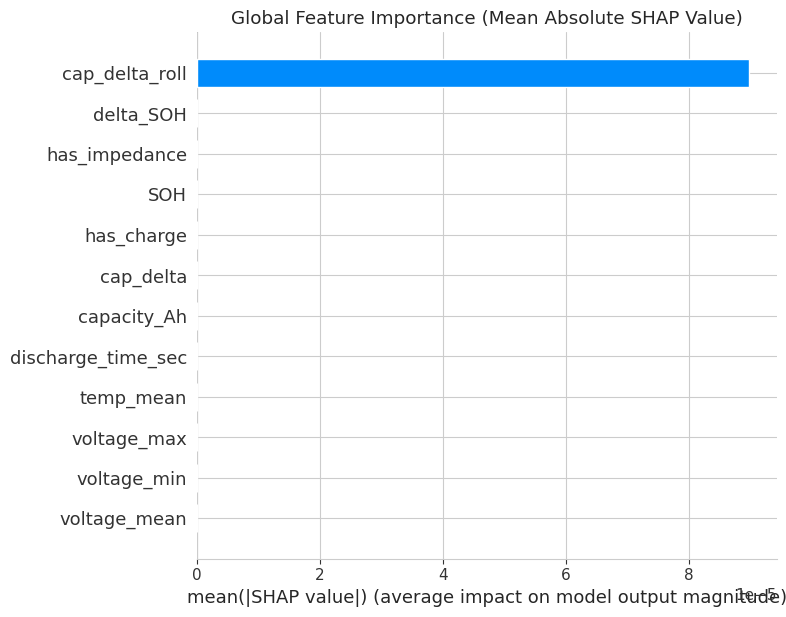

In [147]:
# Generate global feature importance bar plot
shap.summary_plot(
    shap_values_val,
    X_val,
    plot_type="bar",
    show=False # Prevent immediate display, allowing custom titles/layouts
)
plt.title("Global Feature Importance (Mean Absolute SHAP Value)")
plt.tight_layout()
plt.show()

### B. Global Impact Distribution (Beeswarm Plot)

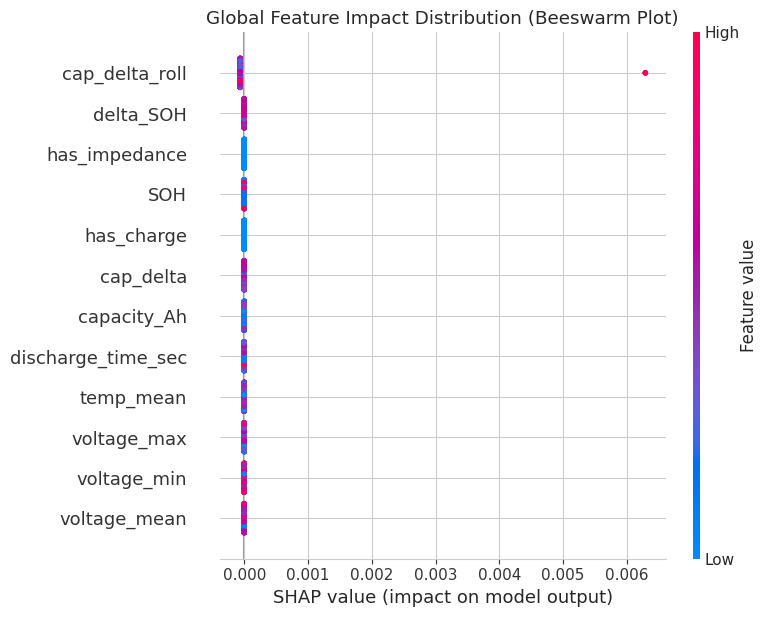

In [148]:
# Generate global impact distribution (beeswarm plot)
shap.summary_plot(
    shap_values_val,
    X_val,
    show=False # Prevent immediate display
)
plt.title("Global Feature Impact Distribution (Beeswarm Plot)")
plt.tight_layout()
plt.show()

## 5. Dependence Plots (Physics Validation)

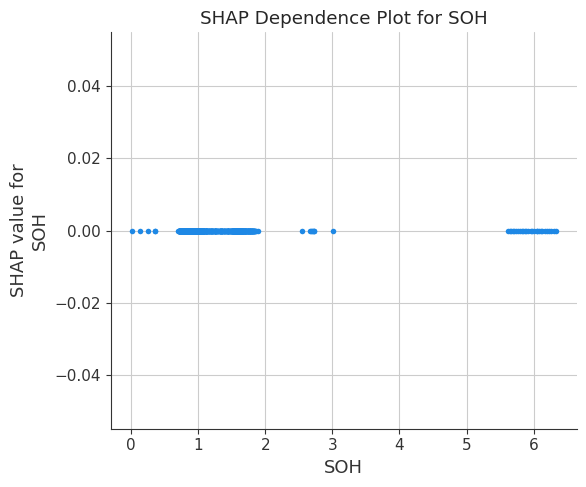

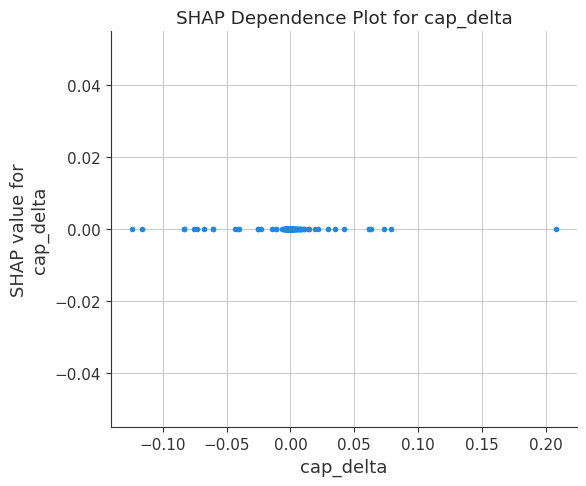

In [149]:
# Generate dependence plot for 'SOH'
shap.dependence_plot(
    "SOH",
    shap_values_val.values,
    X_val,
    interaction_index=None, # Show primary dependence only
    show=False
)
plt.title("SHAP Dependence Plot for SOH")
plt.tight_layout()
plt.show()

# Generate dependence plot for 'cap_delta'
shap.dependence_plot(
    "cap_delta",
    shap_values_val.values,
    X_val,
    interaction_index=None, # Show primary dependence only
    show=False
)
plt.title("SHAP Dependence Plot for cap_delta")
plt.tight_layout()
plt.show()

## 6. Local Explanation (Waterfall Plot)

Explaining validation sample at index: 0
Original features: {'voltage_mean': 3.561329873566011, 'voltage_min': 2.752525349487656, 'voltage_max': 4.209633039423311, 'temp_mean': 24.0, 'discharge_time_sec': 196.0, 'capacity_Ah': 0.0816666666666666, 'cap_delta': -0.0004166666666666, 'cap_delta_roll': -0.00125, 'has_charge': 0.0, 'has_impedance': 0.0, 'SOH': 1.0, 'delta_SOH': 0.0}


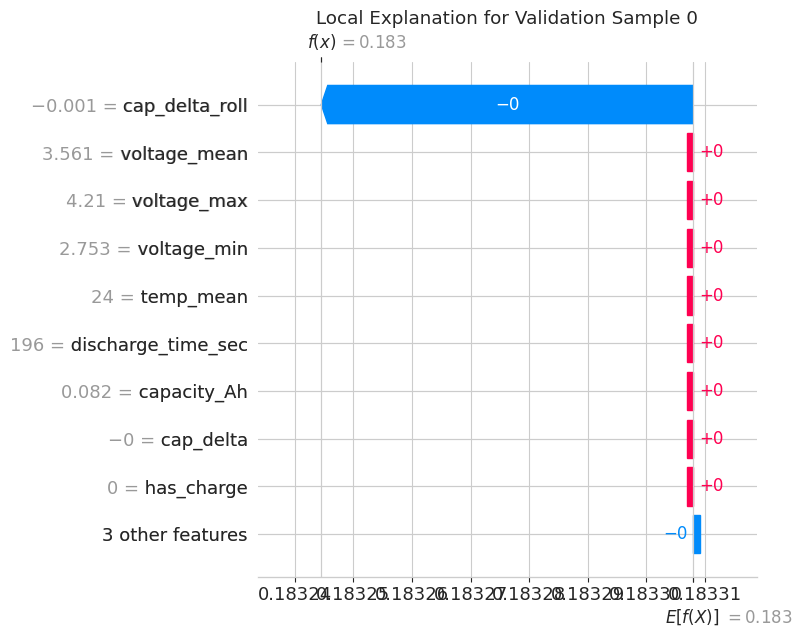

In [150]:
# Select a single instance from the validation set for local explanation
# Using the first sample (index 0) for simplicity
sample_index_to_explain = 0
single_instance_X = X_val.iloc[sample_index_to_explain]
single_instance_shap_values = shap_values_val[sample_index_to_explain]

print(f"Explaining validation sample at index: {sample_index_to_explain}")
print(f"Original features: {single_instance_X.to_dict()}")

# Generate waterfall plot for the local explanation
shap.plots.waterfall(single_instance_shap_values, show=False)
plt.title(f"Local Explanation for Validation Sample {sample_index_to_explain}")
plt.tight_layout()
plt.show()